For this project we are going to try to predict whether a patient has a heart disease or not based on certain features that are explained below.

About this dataset

1) Age : Age of the patient

2) Sex : Sex of the patient
    - 0 = female
    - 1 = male

3) cp : Chest Pain type chest pain type

    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic

4) trtbps : resting blood pressure (in mm Hg)

5) chol : cholestoral in mg/dl fetched via BMI sensor

6) fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

7) rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

8) thalach : maximum heart rate achieved

9) exang: exercise induced angina (1 = yes; 0 = no)

10) oldpeak: ST depression induced by exercise relative to rest

11) slp: Slope -  the slope of the peak exercise ST segment
    
    - 0 = unsloping
    - 1 = flat
    - 2 = downsloping

12) caa: number of major vessels (0-3)

13) thall: thalassemia
    
    - 0 = null
    - 1 = fixed defect
    - 2 = normal
    - 3 = reversable defect

14) output : 0= less chance of heart attack 1= more chance of heart attack

Let's clone my repository so we could have acsess to the data.

In [1]:
!git clone https://github.com/PolyakovMA/heart-disease-ml

Cloning into 'heart-disease-ml'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 4), reused 7 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 1.42 MiB | 13.87 MiB/s, done.
Resolving deltas: 100% (4/4), done.


Let's move to our working directory and import everything we need.

In [2]:
%cd heart-disease-ml

/content/heart-disease-ml


In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

We should load the data into a dataframe:

In [9]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Check the amount of data, it's a small dataset:

In [10]:
df.shape

(303, 14)

Check data types in case we need some data transformation. Everything is prepared for exploring and training.

In [11]:
df.dtypes.value_counts()

,count
int64,13
float64,1


Check for missing values: there are no missing values.

In [12]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trtbps,0
chol,0
fbs,0
restecg,0
thalachh,0
exng,0
oldpeak,0


Next we should split our features into numerical and categorical:

In [13]:
numerical = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']

The features below have more than 2 values and it makes sense to use OneHotEncoder on them, especially for models such as LogisticRegression, SVM and KNN:

In [14]:
one_hot_features = df[categorical].nunique().loc[lambda x: x > 2]
one_hot_features

,0
cp,4
restecg,3
slp,3
caa,5
thall,4


Extract names of the festures we are going to encode using OneHotEncoder

In [16]:
one_hot_names = one_hot_features.index
one_hot_names

Index(['cp', 'restecg', 'slp', 'caa', 'thall'], dtype='object')

Check the countplot for our one-hot features. If some categories have too few instances, it may cause problems later during OneHot encoding: certain categories could end up only in the test set, making them unknown to the model at prediction time. To handle this issue, we will use handle_unknown='ignore' inside OneHotEncoder.

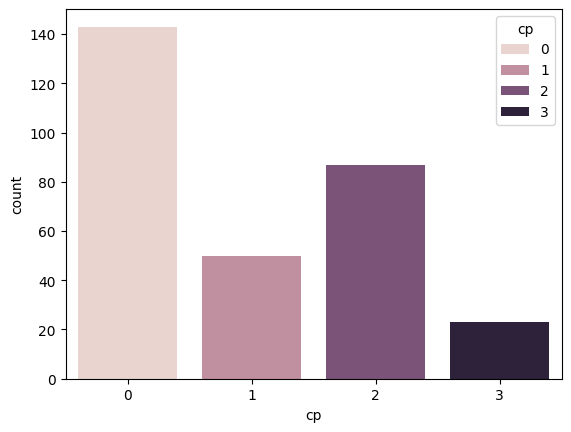

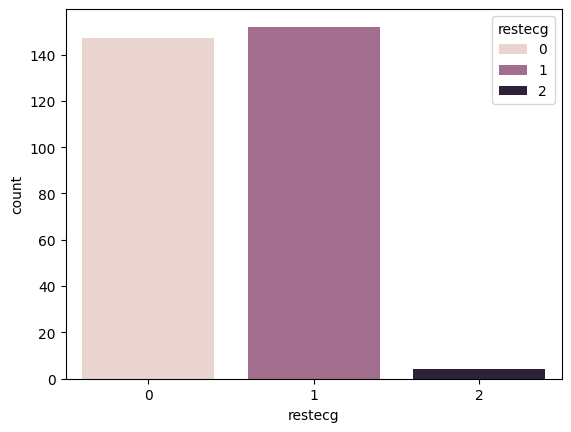

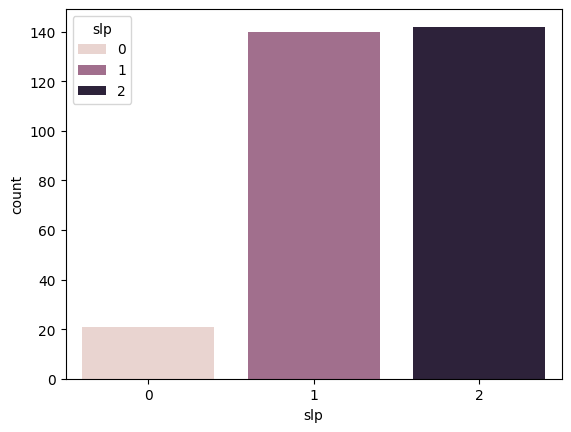

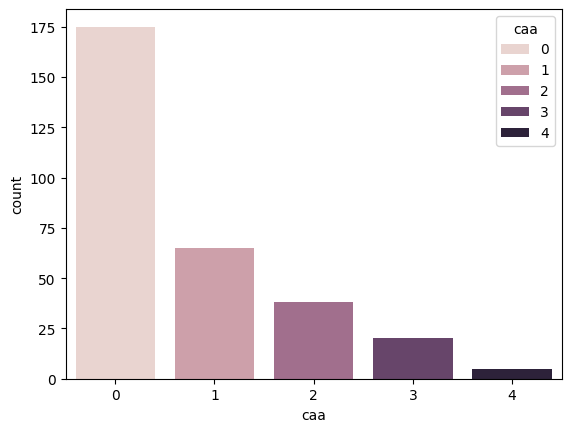

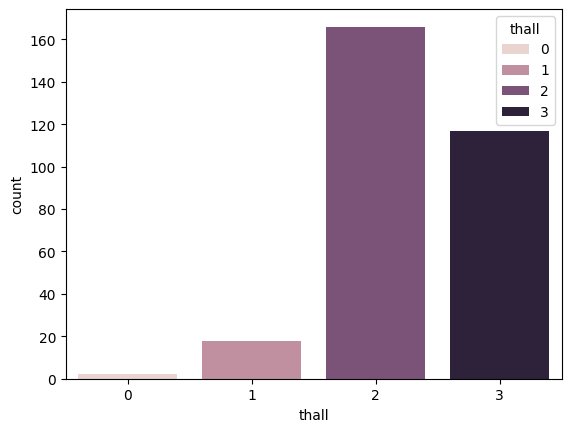

In [17]:
for feat in one_hot_names:
    fig, ax = plt.subplots()
    sns.countplot(x=df[feat], ax=ax, hue=df[feat])
    plt.show()

Let's calculate correlation between numerical columns and target variable:

In [18]:
correlation = df[numerical + ['output']].corr()
correlation

,age,trtbps,chol,thalachh,oldpeak,output
age,1.000000,0.279351,0.213678,-0.398522,0.210013,-0.225439
trtbps,0.279351,1.000000,0.123174,-0.046698,0.193216,-0.144931
chol,0.213678,0.123174,1.000000,-0.009940,0.053952,-0.085239
thalachh,-0.398522,-0.046698,-0.009940,1.000000,-0.344187,0.421741
oldpeak,0.210013,0.193216,0.053952,-0.344187,1.000000,-0.430696
output,-0.225439,-0.144931,-0.085239,0.421741,-0.430696,1.000000


And сonvert the table into a heatmap for better visualization:

<Axes: title={'center': 'Correlation Matrix'}>

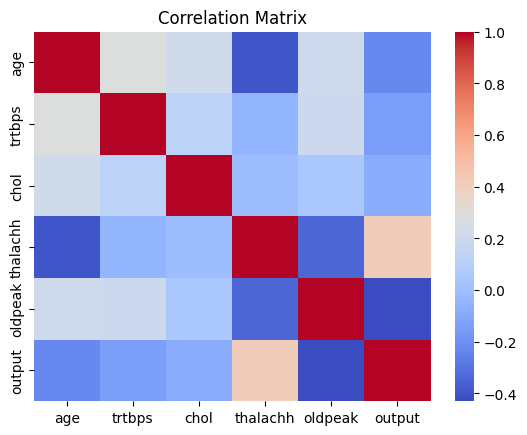

In [19]:
correlation_matrix = sns.heatmap(correlation, cmap='coolwarm')
plt.title('Correlation Matrix')
correlation_matrix

It looks like there are no strong dependencies for our target variable, though we can highlight oldpeak, thalachh and age.
We also observe some weak multicollinearity between age – thalachh and oldpeak – thalachh. Since there are no strong correlations between the features, we will keep all of them in the model without removing any.

Before building a Logistic Regression model, our features need to be scaled. Typically, we use StandardScaler for Logistic Regression, but first we should ensure that the numerical features are approximately normally distributed. This is important because normally distributed features improve the stability of the model coefficients and make the optimization process more efficient.

In [20]:
numerical

['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

The first four features roughly follow a normal or log-normal distribution (with some right- or left-skewed tails), whereas oldpeak resembles an exponential distribution, which may cause issues for our model:

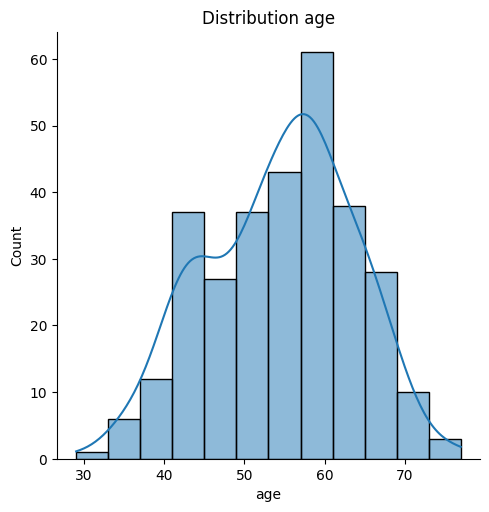

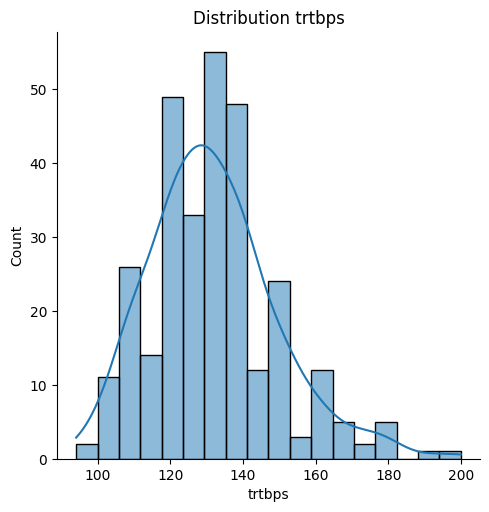

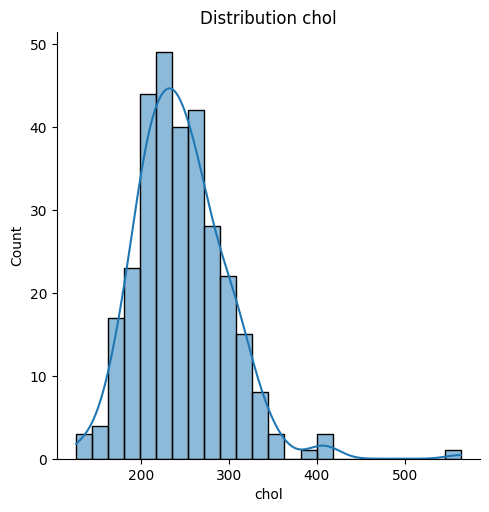

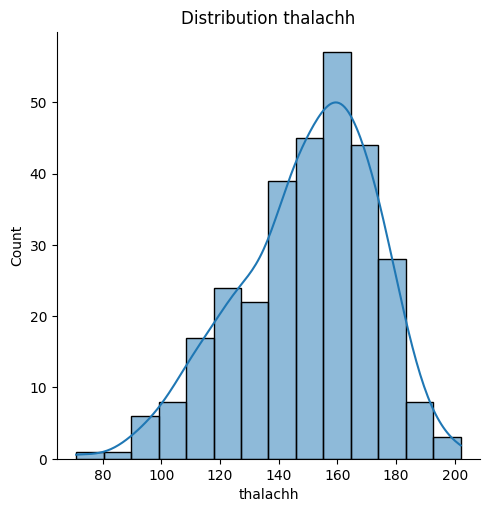

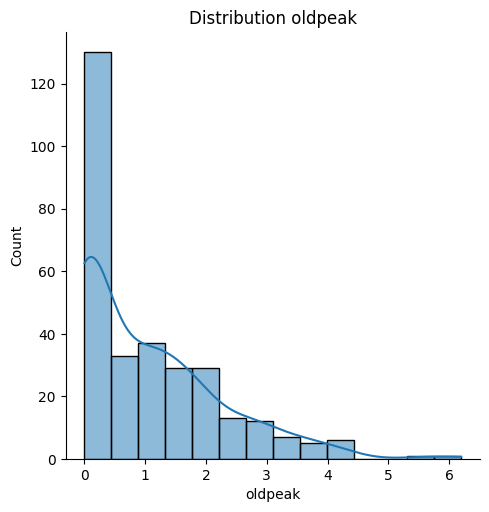

In [21]:
for feature in numerical:
    sns.displot(df[feature], kde=True)
    plt.title(f'Distribution {feature}')
    plt.show()

NormaltestResult(statistic=7.891249686187957, pvalue=0.019339128672619218)
NormaltestResult(statistic=0.09593635589249787, pvalue=0.9531641182347064)
NormaltestResult(statistic=5.708559226786853, pvalue=0.05759729850163692)
NormaltestResult(statistic=4.9792735162625075, pvalue=0.08294008841679495)


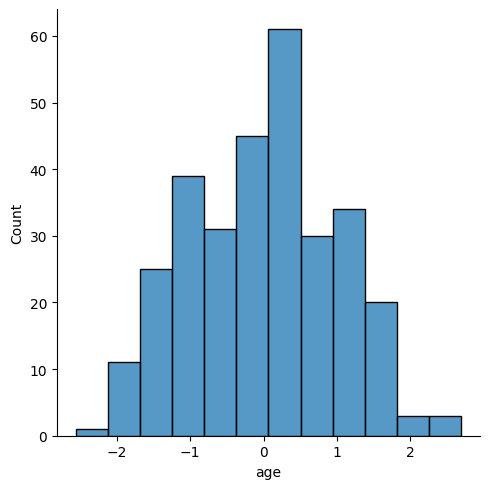

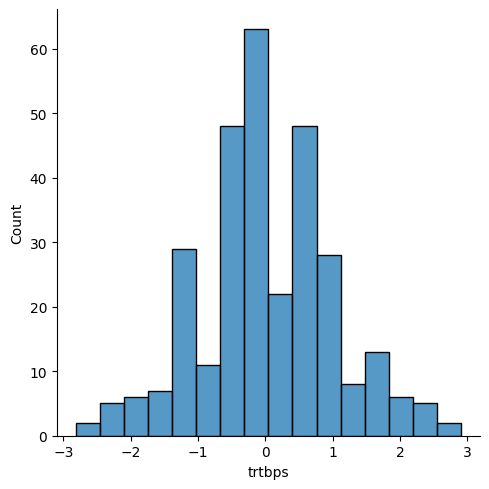

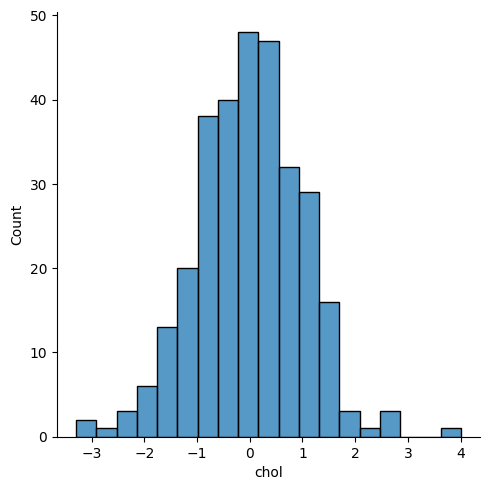

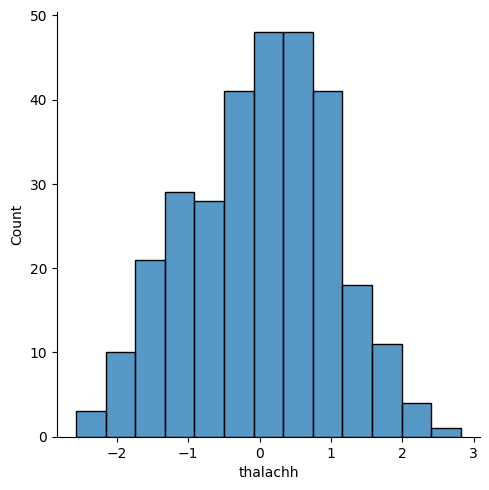

In [ ]:
#Let's bring first 4 features to normal distribution and create a copy of our dataset
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import normaltest


df_scaled  = df.copy()

# we will ad this later in our pipeline
PT = PowerTransformer(method='yeo-johnson')
to_scale = ['age', 'trtbps', 'chol', 'thalachh']


for feature in to_scale:
    df_scaled[feature] = PT.fit_transform(df_scaled[[feature]])
    print(normaltest(df_scaled[feature]))
    sns.displot(df_scaled[feature])

#as we can see we were able to bring 3 features to normal distribution (p value > 0.05) except for age, but age visually resembles normal distribution so we'll leave it as it is.


In [ ]:
#that's how our df looks now, only 'oldpeak' remains without any transformation
df_scaled.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.956171,1,3,0.831717,-0.159046,1,0,-0.081881,0,2.3,0,0,1,1
1,-1.831006,1,2,0.015350,0.187234,0,1,1.871628,0,3.5,0,0,2,1
2,-1.442978,0,1,0.015350,-0.819710,0,0,1.015375,0,1.4,2,0,2,1
3,0.147656,1,1,-0.623762,-0.095947,0,1,1.347213,0,0.8,2,0,2,1
4,0.260722,0,0,-0.623762,1.859954,0,1,0.543973,1,0.6,2,0,2,1


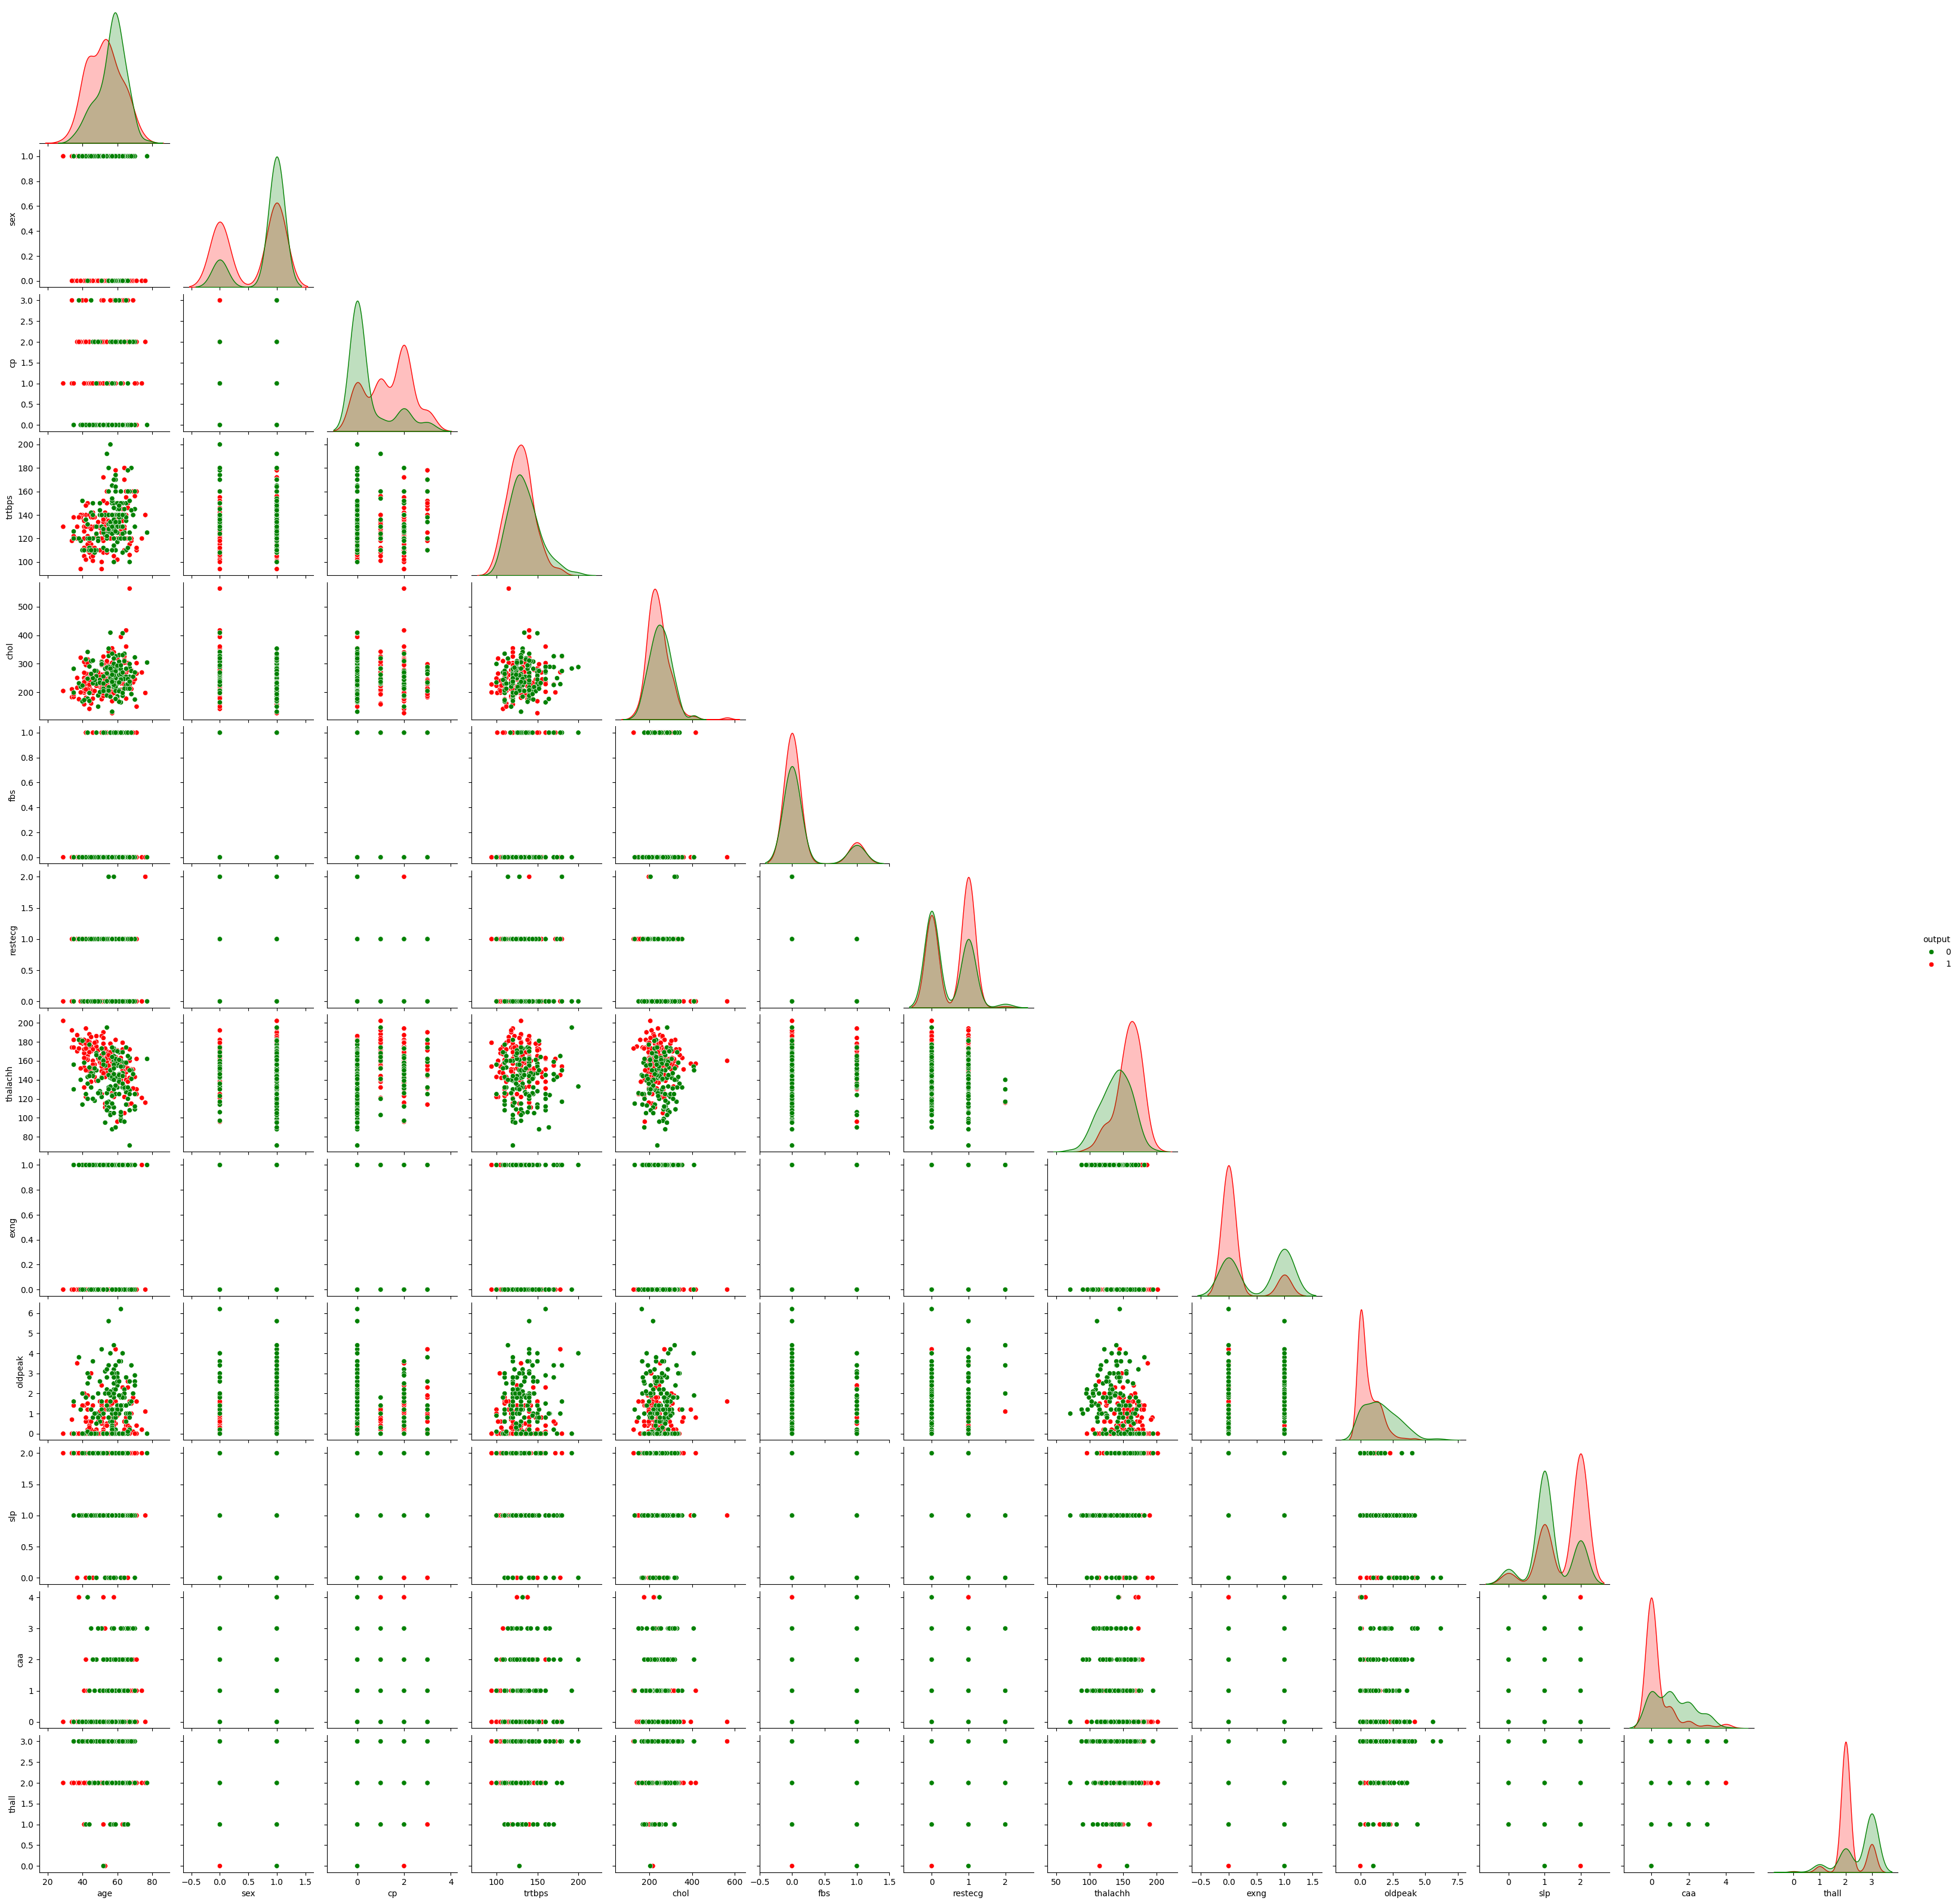

In [ ]:
# We can also make a paiplot to look closely at each feature compared to other features based on a certain class
sns.pairplot(df,
             hue='output',
             corner=True,
             palette=['green', 'red'])

In [ ]:
#looks like the target is more or less balanced, but we are still going tu use stratified split
df['output'].value_counts(normalize=True)

output
1    0.544554
0    0.455446
Name: proportion, dtype: float64

In [ ]:
#lets transform oldpeak into a catergorical variable where labesls are encoded from 0 to 3 and reflect 'Normal', 'Mild', 'Severe', 'Critical'
#this transformation doesn't improve Logostic regression - best way to leave oldpeak feature as it is


#df['oldpeak_cat'] = pd.cut(df['oldpeak'], bins=[-float('inf'), 0, 2, 4, float('inf')], labels=[0, 1, 2, 3])
#df.drop(columns='oldpeak', inplace=True)
#pop = df.pop('output')
#df['output'] = pop
#df.head()


In [ ]:
# define features and target

X = df.iloc[:, :-1]
display(X.head())

y = df.iloc[:, -1:].values.ravel()
display(y)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#We first split the data, only AFTER THIS we can perform our transformations on the train set to avoid data leakage
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31, stratify=y)

In [ ]:
pd.Series(y_train).value_counts()
pd.Series(y_test).value_counts()

1    33
0    28
Name: count, dtype: int64

In [ ]:
#define a function that will search for best parameters and do cross-validation for each of our models

from sklearn.model_selection import GridSearchCV, StratifiedKFold

def find_the_best_model(estimator, params, X_train, y_train, scoring = 'accuracy'):

    search = GridSearchCV(estimator=estimator,
                          param_grid=params,
                          verbose=1,
                          scoring = scoring,
                          cv=StratifiedKFold(n_splits=3))

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    print("Best parameters:", search.best_params_)
    print("best score:", search.best_score_)

    return search, best_model

In [ ]:
# define a function to create dictionary with various metrics

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score #, confusion_matrix

def get_metrics(model, X_test, y_test):
    result = {}

    pred = model.predict(X_test)

    #for roc_auc metric we need probabilities of a positive class instead of a class itself
    pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, pred)
    precision, recall, f1score, _ = precision_recall_fscore_support(y_test, pred, average='weighted')
    ROC = roc_auc_score(y_test, pred_proba)

    result['Accuracy'] = accuracy
    result['Precision'] = precision
    result['Recall'] = recall
    result['F1 score'] = f1score
    result['ROC'] = ROC

    return result

In [ ]:
# if we dont scale our features it also will be much harder co converge our LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, OneHotEncoder

# in order to use some models like Logistic Regression, SVM and KNN we have to scale some of our features
transform_feat = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

min_max_prep = ColumnTransformer(transformers=[('min_max_scaler', MinMaxScaler(), transform_feat)],
                                 remainder='passthrough')

std_prep = ColumnTransformer(transformers=[('std_scaler', StandardScaler(), transform_feat),
                                           ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_names)],
                                 remainder='passthrough')

PT_prep = ColumnTransformer(transformers=[('pt_scaler', PowerTransformer(method='yeo-johnson'), transform_feat)],
                                 remainder='passthrough')

robust_prep =  ColumnTransformer(transformers=[('robust_scaler', RobustScaler(), transform_feat),
                                               ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_names)],
                                 remainder='passthrough')


In [ ]:
#create a pipeline for Logostic Regression and parameter dictionary that will be used in GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

LR_steps = [('LR_scaler', std_prep),
            ('LR_model', LogisticRegression())]

LR_pipe = Pipeline(steps=LR_steps)

#both liblinear and saga can work with l1 and l2 regularization
L1_L2_params = {'LR_model__penalty': ['l1', 'l2'],
             'LR_model__solver': ['liblinear', 'saga'],
             'LR_model__C': [10**i for i in range(-2, 2)],
             'LR_model__max_iter': [10000]}

#another grid specifically for elasticnet
elasticnet_params = {'LR_model__penalty': ['elasticnet'],
                     'LR_model__solver': ['saga'],
                     'LR_model__C': [10**i for i in range(-2, 2)],
                     'LR_model__l1_ratio': [0.1, 0.5, 0.7],
                     'LR_model__max_iter': [10000]}

LR_params = [L1_L2_params, elasticnet_params]


In [ ]:
# we use f1 as a scoring function, though accuracy gives pretty much the same result (here the function returns GridSearchCV object and the best model)
import warnings
warnings.filterwarnings('ignore')

search_LR, LR_best_pipe = find_the_best_model(estimator=LR_pipe, params=LR_params, X_train=X_train, y_train=y_train, scoring='f1')

warnings.filterwarnings('default')

Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best parameters: {'LR_model__C': 10, 'LR_model__max_iter': 10000, 'LR_model__penalty': 'l2', 'LR_model__solver': 'liblinear'}
best score: 0.8591474086436749


In [ ]:
#NOTE that random_state in train_test_split CAN AFFECT the final score (check random_state=0 for example). This can be due to the small dataset
#call the function we defined earlier
LR_metrics = get_metrics(LR_best_pipe, X_test, y_test)
LR_metrics

{'Accuracy': 0.8852459016393442,
 'Precision': 0.8881420765027322,
 'Recall': 0.8852459016393442,
 'F1 score': 0.8844927984507591,
 'ROC': 0.9361471861471862}

In [ ]:
#we can look at the GridSearchCV results more closely
results_lr = pd.DataFrame(search_LR.cv_results_)
results_lr.tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LR_model__C,param_LR_model__max_iter,param_LR_model__penalty,param_LR_model__solver,param_LR_model__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.023006,0.000805,0.009997,0.000818,1,10000,elasticnet,saga,0.5,"{'LR_model__C': 1, 'LR_model__l1_ratio': 0.5, ...",0.919540,0.827586,0.808989,0.852038,0.048331,11
24,0.024005,0.001632,0.007673,0.000465,1,10000,elasticnet,saga,0.7,"{'LR_model__C': 1, 'LR_model__l1_ratio': 0.7, ...",0.919540,0.837209,0.808989,0.855246,0.046900,5
25,0.029673,0.000943,0.009002,0.001415,10,10000,elasticnet,saga,0.1,"{'LR_model__C': 10, 'LR_model__l1_ratio': 0.1,...",0.904762,0.813953,0.847826,0.855514,0.037469,3
26,0.031999,0.004546,0.008676,0.000950,10,10000,elasticnet,saga,0.5,"{'LR_model__C': 10, 'LR_model__l1_ratio': 0.5,...",0.904762,0.813953,0.838710,0.852475,0.038329,8
27,0.033337,0.006012,0.010002,0.001637,10,10000,elasticnet,saga,0.7,"{'LR_model__C': 10, 'LR_model__l1_ratio': 0.7,...",0.904762,0.813953,0.838710,0.852475,0.038329,8


In [ ]:
# and we will also look at feature importance using permutation_importance
from sklearn.inspection import permutation_importance

result = permutation_importance(LR_best_pipe, X_test, y_test, n_repeats=10, random_state=42)
importance = result.importances_mean
features = X_train.columns

array([ 0.00000000e+00,  4.91803279e-02,  8.52459016e-02,  8.19672131e-03,
        1.47540984e-02, -3.27868852e-03, -1.63934426e-03,  2.13114754e-02,
        4.91803279e-03,  1.11022302e-17, -1.63934426e-03,  7.70491803e-02,
        2.95081967e-02])

In [ ]:
#create a DataFrame (all features have kind of low importance)
df_imp = pd.DataFrame({'Features': features, 'Importance': importance})
df_imp.sort_values(by='Importance', ascending=False)

,Features,Importance
2,cp,8.524590e-02
11,caa,7.704918e-02
1,sex,4.918033e-02
12,thall,2.950820e-02
7,thalachh,2.131148e-02
4,chol,1.475410e-02
3,trtbps,8.196721e-03
8,exng,4.918033e-03
9,oldpeak,1.110223e-17
0,age,0.000000e+00


The above dataframe claims the that following features have no importance for our Logisticregression model:

    - cholestoral
    - fasting blood sugar
    - resting electrocardiographic results

We will try to find out later whether this model is 'too simple' to understand our dataset

In [ ]:
#next we will try KNN

from sklearn.neighbors import KNeighborsClassifier

KNN_steps = [('KNN_scaler', std_prep),
            ('KNN_model', KNeighborsClassifier())]

KNN_pipe = Pipeline(steps=KNN_steps)

KNN_params = {'KNN_model__n_neighbors': [3, 5, 7, 10],
             'KNN_model__weights': ['uniform', 'distance'],
             'KNN_model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             'KNN_model__metric': ['euclidean', 'manhattan']}


In [ ]:
warnings.filterwarnings('ignore')

search_KNN, KNN_best_pipe = find_the_best_model(estimator=KNN_pipe, params=KNN_params, X_train=X_train, y_train=y_train, scoring='f1')

warnings.filterwarnings('default')

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters: {'KNN_model__algorithm': 'auto', 'KNN_model__metric': 'manhattan', 'KNN_model__n_neighbors': 10, 'KNN_model__weights': 'uniform'}
best score: 0.8456670541133927


In [ ]:
#call the function we defined earlier - the result are slightly worse than of LogisticRegression
KNN_metrics = get_metrics(KNN_best_pipe, X_test, y_test)
KNN_metrics

{'Accuracy': 0.7540983606557377,
 'Precision': 0.7550346240814019,
 'Recall': 0.7540983606557377,
 'F1 score': 0.7543638415079313,
 'ROC': 0.8836580086580086}

In [ ]:
from sklearn.svm import SVC

SVM_steps = [('SVM_scaler', PT_prep),
            ('SVM_model', SVC(probability=True))]

SVM_pipe = Pipeline(steps=SVM_steps)

SVM_params = {'SVM_model__C': [0.1, 1, 6, 10, 100],
             'SVM_model__kernel': ['linear', 'rbf'],
             'SVM_model__gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1],
             'SVM_model__class_weight': [None, 'balanced']}


In [ ]:
search_SVM, SVM_best_pipe = find_the_best_model(estimator=SVM_pipe, params=SVM_params, X_train=X_train, y_train=y_train, scoring='f1')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'SVM_model__C': 6, 'SVM_model__class_weight': None, 'SVM_model__gamma': 0.01, 'SVM_model__kernel': 'rbf'}
best score: 0.8588827579701942


In [ ]:
SVM_metrics = get_metrics(SVM_best_pipe, X_test, y_test)
SVM_metrics

{'Accuracy': 0.8852459016393442,
 'Precision': 0.8946243013092245,
 'Recall': 0.8852459016393442,
 'F1 score': 0.8836613380055325,
 'ROC': 0.9426406926406926}

In [ ]:
# this thing likes to overfit
from sklearn.tree import DecisionTreeClassifier
DT_steps = [('DT_model', DecisionTreeClassifier())]

DT_pipe = Pipeline(steps=DT_steps)

DT_params = {'DT_model__criterion': ['gini', 'entropy'],
              'DT_model__max_depth': [None, 10, 20, 30, 50],
              'DT_model__min_samples_split': [2, 5, 10],
              'DT_model__min_samples_leaf': [2, 4, 8],
              'DT_model__max_features': [None, 'sqrt', 'log2'],
              'DT_model__class_weight': [None, 'balanced'],
              'DT_model__random_state': [42]}


In [ ]:
search_DT, DT_best_pipe = find_the_best_model(estimator=DT_pipe, params=DT_params, X_train=X_train, y_train=y_train, scoring='recall')

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best parameters: {'DT_model__class_weight': None, 'DT_model__criterion': 'gini', 'DT_model__max_depth': None, 'DT_model__max_features': None, 'DT_model__min_samples_leaf': 8, 'DT_model__min_samples_split': 2, 'DT_model__random_state': 42}
best score: 0.8106060606060606


In [ ]:
DT_metrics = get_metrics(DT_best_pipe, X_test, y_test)
DT_metrics

{'Accuracy': 0.819672131147541,
 'Precision': 0.8213661202185794,
 'Recall': 0.819672131147541,
 'F1 score': 0.8184886832797643,
 'ROC': 0.875}

In [ ]:
from sklearn.tree import export_text, plot_tree

res = export_text(DT_best_pipe.named_steps['DT_model'], feature_names=list(X_train.columns))
print(res)

|--- cp <= 0.50
|   |--- caa <= 0.50
|   |   |--- thall <= 2.50
|   |   |   |--- exng <= 0.50
|   |   |   |   |--- oldpeak <= 0.25
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- oldpeak >  0.25
|   |   |   |   |   |--- class: 1
|   |   |   |--- exng >  0.50
|   |   |   |   |--- class: 0
|   |   |--- thall >  2.50
|   |   |   |--- oldpeak <= 0.90
|   |   |   |   |--- class: 0
|   |   |   |--- oldpeak >  0.90
|   |   |   |   |--- class: 0
|   |--- caa >  0.50
|   |   |--- oldpeak <= 0.40
|   |   |   |--- class: 0
|   |   |--- oldpeak >  0.40
|   |   |   |--- sex <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- sex >  0.50
|   |   |   |   |--- class: 0
|--- cp >  0.50
|   |--- thall <= 2.50
|   |   |--- oldpeak <= 1.70
|   |   |   |--- age <= 55.50
|   |   |   |   |--- thalachh <= 152.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- thalachh >  152.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- age >  55.50
|   |   |   |   |--- sex <= 0.50
|   |   |   |   |  

In [ ]:
#first split was on chest pain meaning if a person has a chest pain there's a high chance there could be possible heart desease

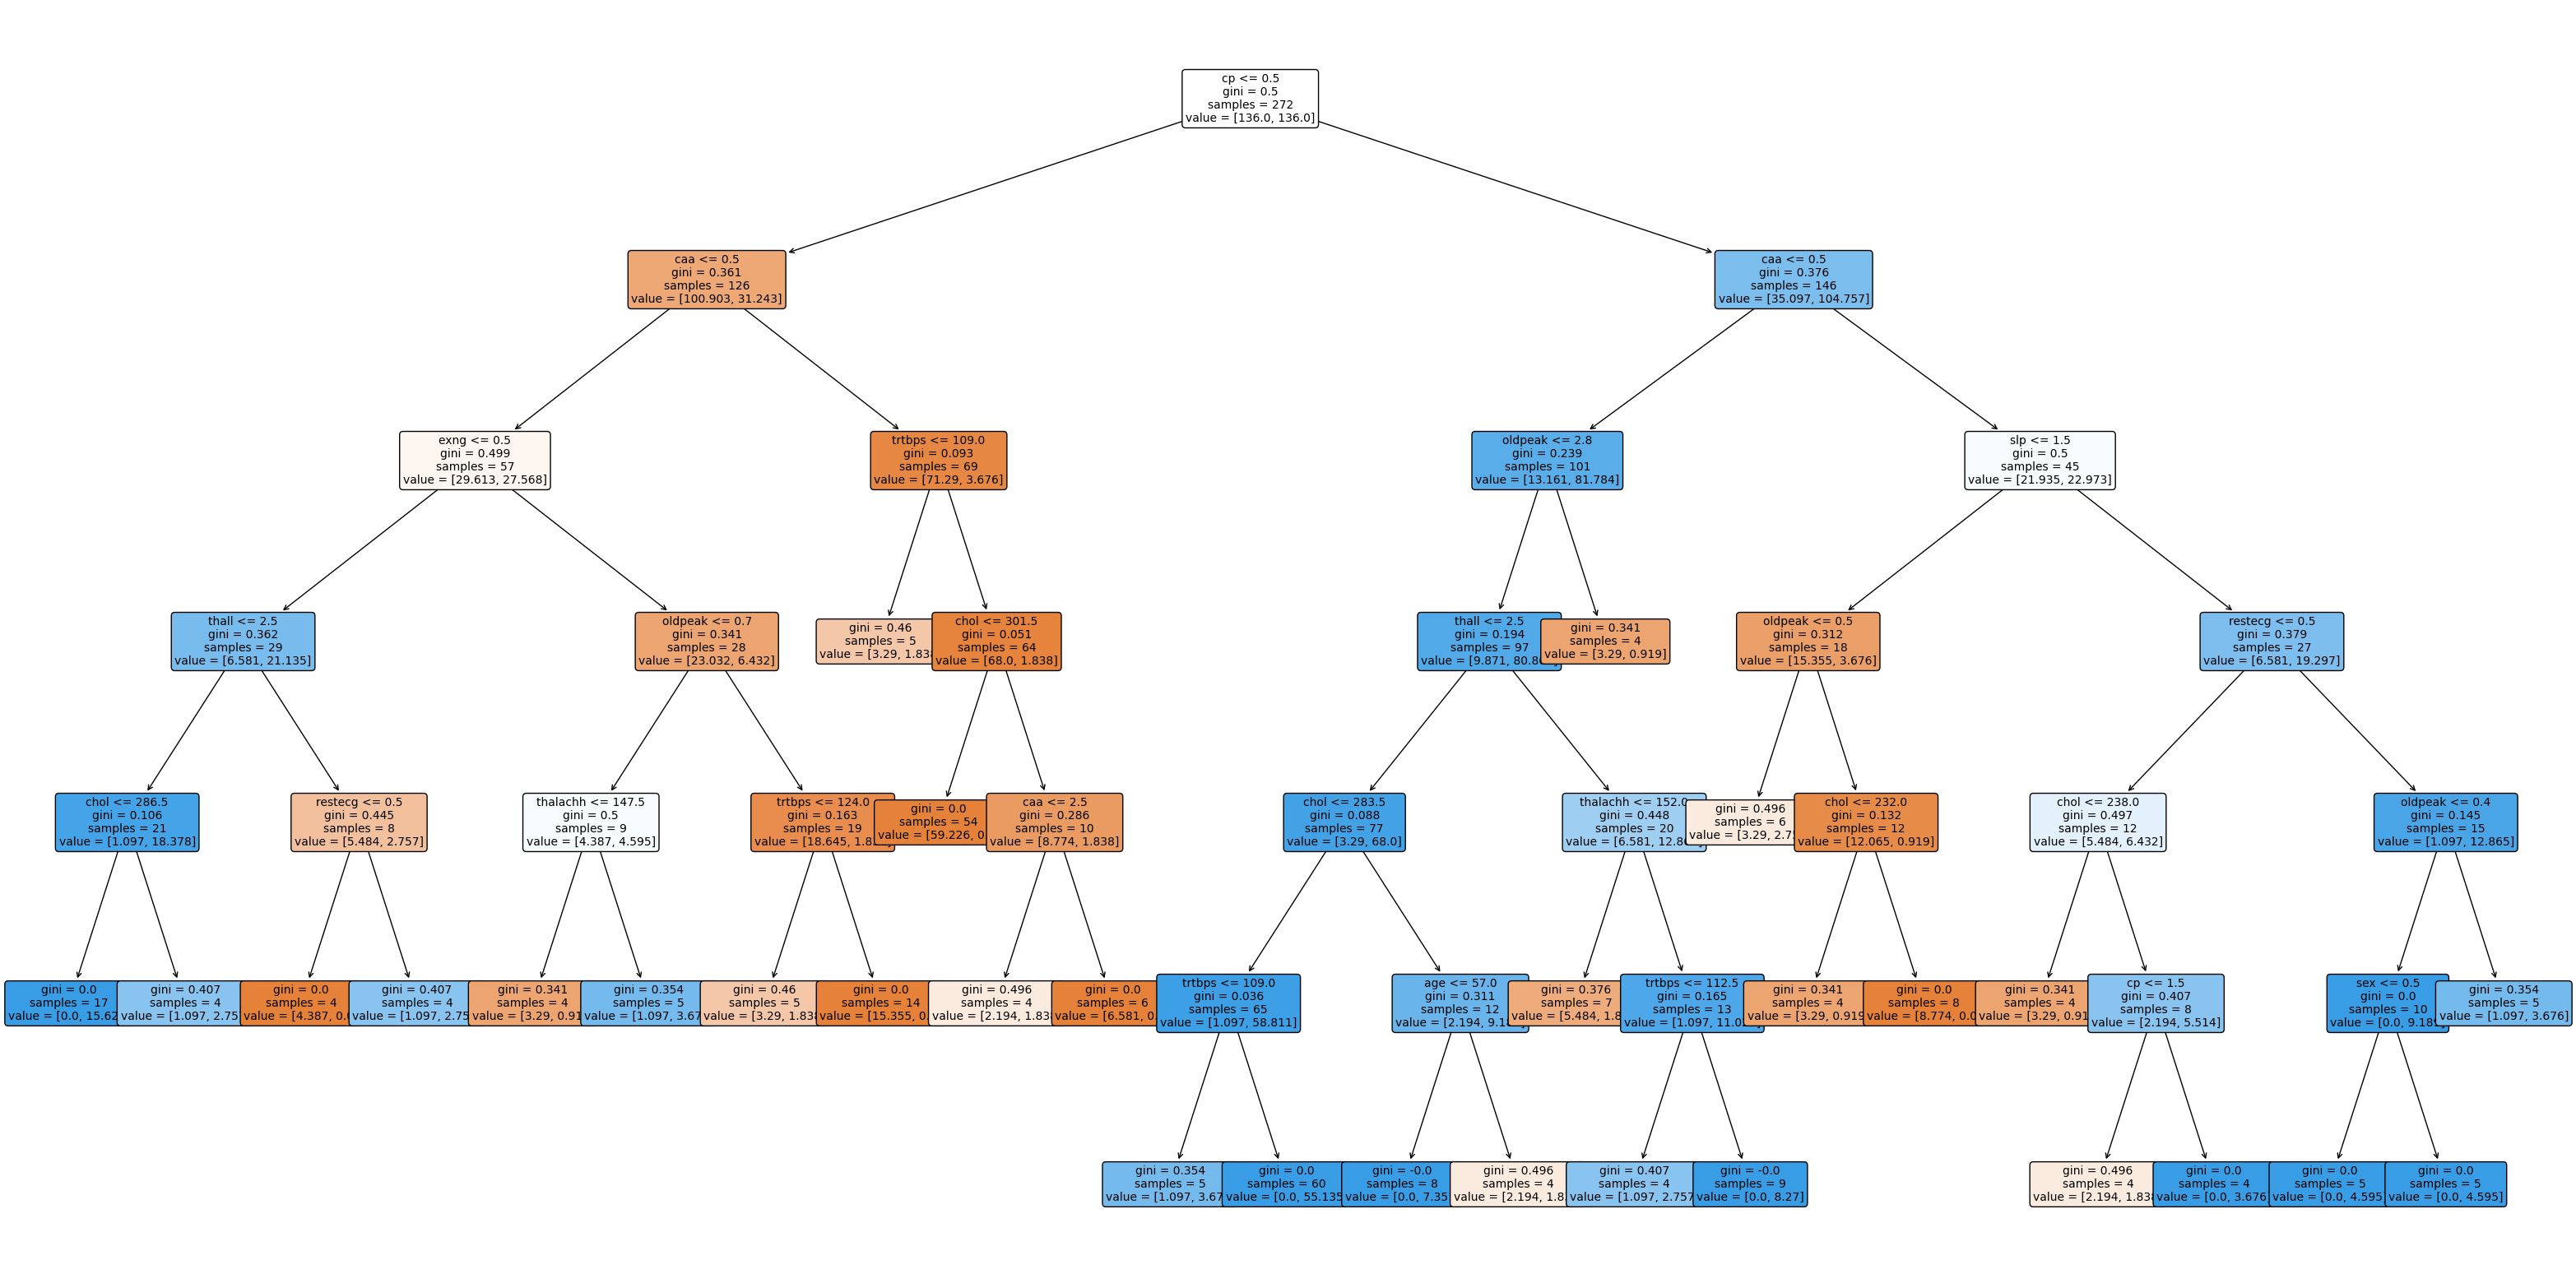

In [ ]:
plt.figure(figsize=(40, 20))
plot_tree(DT_best_pipe.named_steps['DT_model'],
          feature_names=list(X_train.columns),
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_steps = [('RF_model', RandomForestClassifier())]

RF_pipe = Pipeline(steps=RF_steps)

RF_params = {'RF_model__n_estimators': [50, 100, 200],
             'RF_model__criterion': ['gini', 'entropy'],
             'RF_model__max_depth': [10, 20, 30],
             'RF_model__min_samples_split': [5, 10, 15],
             'RF_model__min_samples_leaf': [2, 4, 6],
             'RF_model__max_features': ['sqrt', 'log2'],
             'RF_model__random_state': [42]
             }

In [ ]:
search_RF, RF_best_pipe = find_the_best_model(estimator=RF_pipe, params=RF_params, X_train=X_train, y_train=y_train, scoring='f1')

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'RF_model__criterion': 'gini', 'RF_model__max_depth': 10, 'RF_model__max_features': 'sqrt', 'RF_model__min_samples_leaf': 4, 'RF_model__min_samples_split': 10, 'RF_model__n_estimators': 200, 'RF_model__random_state': 42}
best score: 0.8661212404550414


In [ ]:
RF_metrics = get_metrics(RF_best_pipe, X_test, y_test)
RF_metrics

{'Accuracy': 0.8360655737704918,
 'Precision': 0.8402747009304387,
 'Recall': 0.8360655737704918,
 'F1 score': 0.8344442442803099,
 'ROC': 0.9080086580086579}

In [ ]:
pd.DataFrame(search_RF.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RF_model__criterion,param_RF_model__max_depth,param_RF_model__max_features,param_RF_model__min_samples_leaf,param_RF_model__min_samples_split,param_RF_model__n_estimators,param_RF_model__random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055696,0.007596,0.003338,0.000477,gini,10,sqrt,2,5,50,42,"{'RF_model__criterion': 'gini', 'RF_model__max...",0.923077,0.835165,0.786517,0.848253,0.056513,289
1,0.104027,0.009085,0.005664,0.000945,gini,10,sqrt,2,5,100,42,"{'RF_model__criterion': 'gini', 'RF_model__max...",0.943820,0.831461,0.795455,0.856912,0.063187,103
2,0.188503,0.001433,0.008149,0.000644,gini,10,sqrt,2,5,200,42,"{'RF_model__criterion': 'gini', 'RF_model__max...",0.954545,0.831461,0.786517,0.857508,0.071027,79
3,0.049012,0.000001,0.004000,0.000001,gini,10,sqrt,2,10,50,42,"{'RF_model__criterion': 'gini', 'RF_model__max...",0.911111,0.847826,0.795699,0.851545,0.047190,253
4,0.100708,0.008752,0.005340,0.000466,gini,10,sqrt,2,10,100,42,"{'RF_model__criterion': 'gini', 'RF_model__max...",0.943820,0.813187,0.804348,0.853785,0.063767,181


In [ ]:
#Now let's create a DataFrame with our results from LogisticRegression, KNN< SVM, DesicionTree and RandomForest

result = pd.DataFrame([LR_metrics, KNN_metrics, SVM_metrics, DT_metrics, RF_metrics], index=['LogisticRegression', 'KNN', 'SVM', 'DecisionTree', 'RandomForest'])
result.sort_values(by='F1 score')

,Accuracy,Precision,Recall,F1 score,ROC
KNN,0.754098,0.755035,0.754098,0.754364,0.883658
DecisionTree,0.819672,0.821366,0.819672,0.818489,0.875000
RandomForest,0.836066,0.840275,0.836066,0.834444,0.908009
SVM,0.885246,0.894624,0.885246,0.883661,0.942641
LogisticRegression,0.885246,0.888142,0.885246,0.884493,0.936147


In [ ]:
#Looks like Linear models such as LogisticRegression and SVM show better results, probably because of the dataset size: it's not too big.
# We can try to further tune hyperparameters of each model in order to get better results, but all in all current results seem sufficient.

In [ ]:
#Маленькие датасеты (до 1000-2000 наблюдений):
#Линейные модели:
#Логистическая регрессия
#Линейная регрессия
#Ridge/Lasso регрессия

#Деревья решений:
#Простые модели (Decision Tree, CART) могут быть полезны, но могут переобучаться.
#Методы с малым количеством гиперпараметров:
#SVM с линейным ядром.

#Средние датасеты (от 2000 до 10000 наблюдений):
#Деревья и ансамбли:
#Random Forest
#Gradient Boosting (например, XGBoost или LightGBM) — часто показывают отличные результаты.

#Методы опорных векторов:
#SVM с нелинейными ядрами (например, RBF), но требуются более мощные вычисления.
#Нейронные сети:
#Простые архитектуры (например, полносвязные сети) могут начать быть полезными.


#Большие датасеты (более 10000 наблюдений):
#Ансамбли и бустинг:

#Gradient Boosting (например, XGBoost или LightGBM) — хорошо справляются с большими данными.
#Нейронные сети:

#Сложные архитектуры (например, CNN для изображений, RNN для последовательных данных) — требуют много данных для обучения.
#Сложные модели:

#Сложные ансамбли, такие как Stacking, могут дать улучшения в производительности.
#Общие рекомендации:
#Проверка на переобучение: С увеличением размера датасета, модели могут стать более сложными, но это также увеличивает риск переобучения. Используйте кросс-валидацию для оценки модели.

#Масштабируемость: Для очень больших наборов данных может потребоваться использование распределенных вычислений или специальные библиотеки (например, Dask или Spark).

#Интерпретируемость: Если вам нужно объяснить модель, линейные модели или деревья решений могут быть предпочтительными из-за их интерпретируемости.

#Эти рекомендации могут варьироваться в зависимости от специфики задачи и характера данных, поэтому всегда полезно экспериментировать с различными моделями.